In [16]:
import pandas as pd
import numpy as np
from io import StringIO
from zipfile import ZipFile
from urllib.request import urlopen
import pandas.io.data as web
from datetime import datetime, timedelta
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
%pylab inline
#https://github.com/nakulnayyar/FF3Factor/blob/master/FamaFrench3Factor.ipynb

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [27]:
#url = urlopen("http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_Factors_CSV.zip")

#Download Zipfile and create pandas DataFrame
#zipfile = ZipFile(StringIO(url.read()))
FFdata = pd.read_csv('C:/Users/ywu/Downloads/F-F_Research_Data_Factors.CSV', header = 0, names = ['Date','MKT-RF','SMB','HML','RF'], skiprows=3)
#Drop last row of data - String
FFdata = FFdata[:1074]

#Convert YYYYMM into Date
FFdata['Date'] = pd.to_datetime(FFdata['Date'], format = "%Y%m")
FFdata.index = FFdata['Date']
FFdata.drop(FFdata.columns[0], axis=1,inplace=True)

#Drop Days in YYYY-MM-DD
FFdata.index = FFdata.index.map(lambda x: x.strftime('%Y-%m'))

#Convert into float
FFdata = FFdata.astype('float')
FFdata.tail()

,MKT-RF,SMB,HML,RF
2015-08,-6.04,0.52,2.71,0.00
2015-09,-3.07,-2.61,0.58,0.00
2015-10,7.75,-1.93,-0.11,0.00
2015-11,0.56,3.62,-0.57,0.00
2015-12,-2.17,-2.81,-2.46,0.01


In [33]:
#Get Data from Yahoo
start = '20101231'
end = '20161125'

f = web.get_data_yahoo("IMSSX", start, end, interval='m')

#Delete Columns
f.drop(f.columns[[0,1,2,3,4]], axis=1, inplace=True)
#Fix Date Column
f.index = f.index.map(lambda x: x.strftime('%Y-%m'))
#Ln Return
f['LnReturn'] = np.log(f['Adj Close']) - np.log(f['Adj Close'].shift(1))
f.head()

,Adj Close,LnReturn
2010-12,9.426213,NaN
2011-01,9.557704,0.013853
2011-02,9.911084,0.036306
2011-03,9.607013,-0.031160
2011-04,10.100101,0.050052


In [34]:
#Merge DF
data2 = pd.concat([f,FFdata], axis = 1)

#Excess Return
data2['XRtrn'] = (data2['LnReturn']*100 - data2['RF'])
#Align Data
df = data2[np.isfinite(data2['XRtrn'])]

df.tail()


,Adj Close,LnReturn,MKT-RF,SMB,HML,RF,XRtrn
2015-08,10.793571,-0.080675,-6.04,0.52,2.71,0.00,-8.067474
2015-09,10.202143,-0.056353,-3.07,-2.61,0.58,0.00,-5.635288
2015-10,10.931571,0.069057,7.75,-1.93,-0.11,0.00,6.905723
2015-11,10.892142,-0.003613,0.56,3.62,-0.57,0.00,-0.361341
2015-12,10.790000,-0.009422,-2.17,-2.81,-2.46,0.01,-0.952183


In [38]:
data2.head(5)

,Adj Close,LnReturn,MKT-RF,SMB,HML,RF,XRtrn
1926-07,NaN,NaN,2.96,-2.30,-2.87,0.22,NaN
1926-08,NaN,NaN,2.64,-1.40,4.19,0.25,NaN
1926-09,NaN,NaN,0.36,-1.32,0.01,0.23,NaN
1926-10,NaN,NaN,-3.24,0.04,0.51,0.32,NaN
1926-11,NaN,NaN,2.53,-0.20,-0.35,0.31,NaN


In [39]:
np.isfinite(data2['XRtrn'])

1926-07    False
1926-08    False
1926-09    False
1926-10    False
1926-11    False
1926-12    False
1927-01    False
1927-02    False
1927-03    False
1927-04    False
1927-05    False
1927-06    False
1927-07    False
1927-08    False
1927-09    False
1927-10    False
1927-11    False
1927-12    False
1928-01    False
1928-02    False
1928-03    False
1928-04    False
1928-05    False
1928-06    False
1928-07    False
1928-08    False
1928-09    False
1928-10    False
1928-11    False
1928-12    False
           ...  
2014-06     True
2014-07     True
2014-08     True
2014-09     True
2014-10     True
2014-11     True
2014-12     True
2015-01     True
2015-02     True
2015-03     True
2015-04     True
2015-05     True
2015-06     True
2015-07     True
2015-08     True
2015-09     True
2015-10     True
2015-11     True
2015-12     True
2016-01    False
2016-02    False
2016-03    False
2016-04    False
2016-05    False
2016-06    False
2016-07    False
2016-08    False
2016-09    Fal

In [31]:
#df = data2[np.isfinite(data2['XRtrn'])]

y = df['XRtrn']
X = df.ix[:,[2,3,4]]
X = sm.add_constant(X)


model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  XRtrn   R-squared:                       0.666
Model:                            OLS   Adj. R-squared:                  0.663
Method:                 Least Squares   F-statistic:                     177.0
Date:                Fri, 18 Nov 2016   Prob (F-statistic):           4.34e-63
Time:                        12:21:09   Log-Likelihood:                -572.91
No. Observations:                 270   AIC:                             1154.
Df Residuals:                     266   BIC:                             1168.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.0894      0.126      0.712      0.4

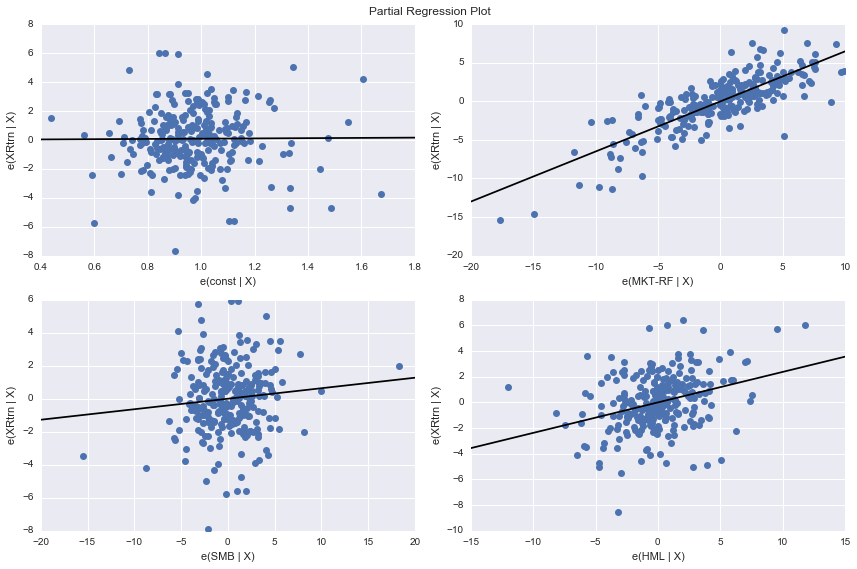

In [32]:

fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_partregress_grid(results, fig = fig)
plt.show()

#sns.lmplot(x="MKT-RF", y="XRtrn", data=data2)